Dans l'exploration et la production de ressources fossiles, la caractérisation des faciès rocheux est essentielle pour l'estimation des propriétés physiques de la roche, telles que la porosité et la perméabilité, ainsi que pour la détection et la simulation des réservoirs.


La porosité est l'ensemble des vides (pores) d'un matériau solide, ces vides sont remplis par des fluides (liquide ou gaz). C'est une grandeur physique comprise entre 0 et 1 (ou, en pourcentage, entre 0 et 100 %), qui conditionne les capacités d'écoulement et de rétention d'un substrat https://fr.wikipedia.org/wiki/Porosit%C3%A9

La perméabilité d'un milieu poreux mesure son aptitude à se laisser traverser par un fluide sous l'effet d'un gradient de pression ou d'un champ de gravité. https://fr.wikipedia.org/wiki/Perm%C3%A9abilit%C3%A9_(fluide)

Je propose dans ce notebook un réseau de neurones convolutifs pour classer les Faciès.

Ce travail est basé sur l'article https://www.researchgate.net/publication/331991539_Characterizing_Rock_Facies_Using_Machine_Learning_Algorithm_Based_on_a_Convolutional_Neural_Network_and_Data_Padding_Strategy

In [1]:
import pandas as pd
import numpy as np


import altair as alt
import matplotlib.pyplot as plt
import seaborn as sns;



from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix



import sklearn
import torchvision
import torchvision.transforms as transforms


from imblearn.over_sampling import SMOTE,RandomOverSampler

from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
torch.manual_seed(42)


In [2]:
print(f'numpy version :{ np.__version__}')
print(f'pandas version :{ pd.__version__}')
print(f'torch version :{ torch.__version__}')
print(f'altair version :{ alt.__version__}')
print(f'seaborn version :{ sns.__version__}')
print(f'scikit learn version :{sklearn.__version__}')

numpy version :1.19.2
pandas version :1.1.3
torch version :1.7.1
altair version :4.1.0
seaborn version :0.11.0
scikit learn version :0.23.2


Les données peuvent être trouvées https://www.kaggle.com/imeintanis/well-log-facies-dataset.

In [3]:
df=pd.read_csv('facies_data.csv')

df=df.drop_duplicates()

In [4]:
df.head()

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
0,3,A1 SH,SHRIMPLIN,2793.0,77.45,0.664,9.9,11.915,4.6,1,1.000
1,3,A1 SH,SHRIMPLIN,2793.5,78.26,0.661,14.2,12.565,4.1,1,0.979
2,3,A1 SH,SHRIMPLIN,2794.0,79.05,0.658,14.8,13.050,3.6,1,0.957
3,3,A1 SH,SHRIMPLIN,2794.5,86.10,0.655,13.9,13.115,3.5,1,0.936
4,3,A1 SH,SHRIMPLIN,2795.0,74.58,0.647,13.5,13.300,3.4,1,0.915


In [5]:
df.shape

(3231, 11)

Nous avons 3231 rows et 11 variables.

Les variables caractéristiques comprennent cinq des mesures logarithmiques filaires et deux variables de contrainte géologique dérivées des connaissances géologiques.



Les sept variables sont:

1. GR: this wireline logging tools measure gamma emission
2. ILD_log10: this is resistivity measurement
3. PE: photoelectric effect log
4. DeltaPHI: Phi is a porosity index in petrophysics.
5. PNHIND: Average of neutron and density log.
6. NM_M:nonmarine-marine indicator
7. RELPOS: relative position

les différentes classes de Faciès sont:

* SS: Nonmarine sandstone
* CSiS: Nonmarine coarse siltstone
* FSiS: Nonmarine fine siltstone
* SiSH: Marine siltstone and shale
* MS: Mudstone (limestone)
* WS: Wackestone (limestone)
* D: Dolomite
* PS: Packstone-grainstone (limestone)
* BS: Phylloid-algal bafflestone (limestone)


Les limites de faciès étant continues plutôt que discrètes, les propriétés mesurées pour différentes classes se chevauchent dans l'espace des fonctions et donc le tableau suivant liste les faciès, avec les faciès adjacents.

Un algorithme de classification fera peut être des erreurs, entre les facies et leurs adjacents.

In [41]:
Facies=range(1,10)
Facies_name=['SS','CSiS','FSiS','SiSh','MS','WS','D','PS','BS']
adjacent_facies = [[2], [1, 3], [2], [5], [4, 6], [5, 7], [6, 8], [6, 7, 9], [7, 8]]



df_adj=pd.DataFrame({'Facies':Facies,'Facies_Name':Facies_name,'adjacent_facies':adjacent_facies})

df_adj

,Facies,Facies_Name,adjacent_facies
0,1,SS,[2]
1,2,CSiS,"[1, 3]"
2,3,FSiS,[2]
3,4,SiSh,[5]
4,5,MS,"[4, 6]"
5,6,WS,"[5, 7]"
6,7,D,"[6, 8]"
7,8,PS,"[6, 7, 9]"
8,9,BS,"[7, 8]"


In [7]:
df.describe()

,Facies,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
count,3231.000000,3231.000000,3231.000000,3231.000000,3231.000000,3231.000000,3231.000000,3231.000000,3231.000000
mean,4.420922,2875.803466,66.083567,0.642759,3.559289,13.483855,3.724681,1.498298,0.520325
std,2.503839,131.021059,30.716527,0.241872,5.229719,7.700085,0.896091,0.500074,0.286829
min,1.000000,2573.500000,13.250000,-0.025949,-21.832000,0.550000,0.200000,1.000000,0.010000
25%,2.000000,2791.000000,46.914500,0.492500,1.162500,8.343500,3.100000,1.000000,0.273000
50%,4.000000,2893.500000,65.700000,0.624591,3.500000,12.150000,3.551000,1.000000,0.526000
75%,6.000000,2980.000000,79.625000,0.812823,6.436000,16.457500,4.300000,2.000000,0.767500
max,9.000000,3122.500000,361.150000,1.480000,18.600000,84.400000,8.094000,2.000000,1.000000


In [8]:
Facies_Name={1:'SS',2:'CSiS',3:'FSiS', 4:'SiSH',5:'MS',6:'WS',7:'D',8:'PS',9:'BS'}


facies_colors = ['#F4D03F', '#F5B041','#DC7633','#6E2C00',
       '#1B4F72','#2E86C1', '#AED6F1', '#A569BD', '#196F3D']

In [9]:
#J'ajoute les noms des faciès dans mon dataframe qui sont plus explicites

df['Facies_Name']=df.Facies.map(lambda v:Facies_Name[v])

In [10]:
df.head()

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,Facies_Name
0,3,A1 SH,SHRIMPLIN,2793.0,77.45,0.664,9.9,11.915,4.6,1,1.000,FSiS
1,3,A1 SH,SHRIMPLIN,2793.5,78.26,0.661,14.2,12.565,4.1,1,0.979,FSiS
2,3,A1 SH,SHRIMPLIN,2794.0,79.05,0.658,14.8,13.050,3.6,1,0.957,FSiS
3,3,A1 SH,SHRIMPLIN,2794.5,86.10,0.655,13.9,13.115,3.5,1,0.936,FSiS
4,3,A1 SH,SHRIMPLIN,2795.0,74.58,0.647,13.5,13.300,3.4,1,0.915,FSiS


In [11]:
df.isnull().any()

Facies         False
Formation      False
Well Name      False
Depth          False
GR             False
ILD_log10      False
DeltaPHI       False
PHIND          False
PE             False
NM_M           False
RELPOS         False
Facies_Name    False
dtype: bool

Il n'y a pas de valeurs manquantes dans nos données. Regardons à présent la distribution de nos classes.

In [12]:
alt.Chart(df).mark_bar().encode(
    x='count()',
    y='Facies_Name:N',
    color='Facies_Name:N'
        )

alt.Chart(...)

***Imbalanced Data***, les classes ne sont pas toutes bien représentées. La classe CSiS (Nonmarine coarse siltstone) est 7 fois beaucoup plus représentée que la classe D (dolomite). 

In [40]:
df.drop(['NM_M','RELPOS','Facies'],axis=1).groupby('Well Name').mean()


,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,IdxFacies
Well Name,,,,,,,
CHURCHMAN BIBLE,3019.482673,63.683453,0.758757,1.560000,14.011116,3.789926,4.655941
CROSS H CATTLE,2702.360279,72.699285,0.568829,2.466667,15.574850,3.325852,2.127745
LUKE G U,2725.708243,64.777223,0.639690,4.218438,12.953905,3.660705,3.353579
NEWBY,2941.500000,60.733045,0.674812,3.477970,11.625378,3.771706,3.801296
NOLAN,2957.000000,68.693940,0.592400,3.134070,12.197361,3.857947,3.643373
Recruit F9,3038.367647,44.712853,0.567853,1.436515,13.183368,5.460735,8.000000
SHANKLE,2890.502227,65.431180,0.630831,2.348998,15.741125,3.224944,2.576837
SHRIMPLIN,2910.429787,69.057000,0.659987,7.714894,12.175330,4.218723,3.376596


Dans le tableau ci-dessus, je regarde pour chaque wells la moyenne des variables mesurées, les moyennes sont un peu différentes d'un wells à l'autre.

In [14]:

def plot_Facies(data=df,Name='SHRIMPLIN',col_toDrop=['Formation','Well Name','RELPOS','NM_M','Facies']):
    
    '''
    inputs: data: pandas dataframe
            Name: (string) name of well
            col_toDrop: columns to drop
            
    output:
            altair plot
    
    '''
    
    A=df[df['Well Name']==Name].drop(col_toDrop,axis=1).melt('Depth',var_name='Category',value_name='valeur')
    char1=alt.Chart(A).mark_line().transform_filter(
    alt.datum.Category!='Facies_Name').encode(
            x=alt.X('valeur:Q', scale=alt.Scale(zero=False), axis=alt.Axis(title=None)),
            y=alt.Y('Depth:Q',scale=alt.Scale(zero=False,reverse=True)),
            color=alt.Color('Category:N',legend=None),
            column='Category:N',
            order='index:Q'
    ).properties(height=400, width=50, title='Well: '+ Name).resolve_scale(x='independent')
    
    
    
    facies_colors = ['#F4D03F', '#F5B041','#DC7633','#6E2C00','#1B4F72','#2E86C1', '#AED6F1', '#A569BD', '#196F3D']
    domain=['SS','CSiS','FSiS', 'SiSH','MS','WS','D','PS','BS']
    B=df[df['Well Name']==Name]
    char2=alt.Chart(B).mark_bar().encode(
        x=alt.X('count()',axis=alt.Axis(title=None,labels=False,grid=False)),
        y=alt.Y('Depth:Q',scale=alt.Scale(reverse=True), axis=alt.Axis(title=None,labels=False)),
        color=alt.Color('Facies_Name:N',scale=alt.Scale(domain=domain,range=facies_colors))
    ).properties(height=400, width=100)
    
    return alt.hconcat(char1,char2).resolve_scale(color='independent')

In [15]:
plot_Facies()

alt.HConcatChart(...)

In [16]:
corr=df.drop(['Depth','RELPOS','Facies','Formation','Well Name','NM_M'],axis=1).corr()

corr=corr.reset_index().melt('index')
corr.columns=['var1','var2','correlation']
b=alt.Chart(corr).transform_filter(
    alt.datum.var1<alt.datum.var2).encode(
            x=alt.X('var1',axis=alt.Axis(title=None)),
            y=alt.Y('var2',axis=alt.Axis(title=None))
    ).properties(height=200,width=200)

rec=b.mark_rect().encode(
            color='correlation'
        )
text=b.mark_text().encode(
        text=alt.Text('correlation', format='.2f')
)

rec+text

alt.LayerChart(...)

<Figure size 576x432 with 0 Axes>

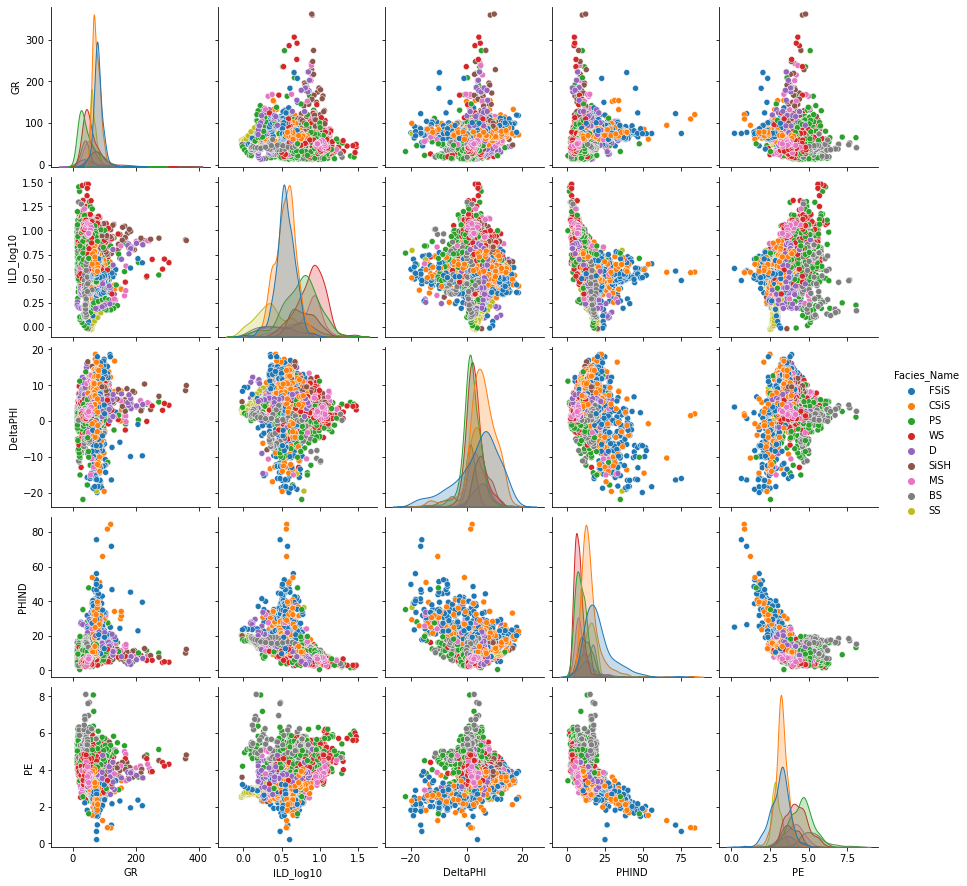

In [17]:
plt.figure(figsize=(8,6));

data=df.drop(['Depth','RELPOS','Facies','Formation','Well Name','NM_M'],axis=1);
sns.pairplot(data, hue='Facies_Name');

Nos variables semblent avoir une relation complexe. Mais on peut remarquer une certaine tendance entre la variable PHIND (Average of neutron and density log) et la variable PE (photoelectric effect log).

In [39]:
WN=np.random.choice(df['Well Name'].unique(),3)

CheckRelPE_PHIND=df[df['Well Name'].isin(WN)][['Well Name','PE','PHIND']]

scatter=alt.Chart(CheckRelPE_PHIND).mark_circle().encode(
                x='PE:Q',
                y='PHIND:Q').properties(height=200,width=200)


scatter = scatter + scatter.transform_regression('PE', 'PHIND',method='log').mark_line(
     color='red',
)



chart = scatter.facet(
    columns=3
    , facet=alt.Facet('Well Name',header=alt.Header(labelFontSize=25))
).resolve_scale(
    x='independent',
    y='independent'
)

chart.display()

alt.FacetChart(...)

La variable ***PE*** photoelectric effect log et la variable *** PHIND***Average of neutron and density log
semble comme avoir un lien logarithmique c'est à dire:

$$PHIND= a+b*log(PE)+\epsilon $$

A vérifier ?

Nous allons essayer de visualiser à présent les données dans le plan.

Pour cela, la procédure est la suivante:

* normalisation StandarScaler

* PCA  en gardant 95% de la variance

* TSNE manifold (pour visualiser dans le plan des données à grande dimension). https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html



In [19]:
df_train=df.drop(['Depth','Facies','Well Name','Facies_Name','Formation'],axis=1) #Je garde les colonnes qui m'intéressent
pipe=Pipeline([('scaler',StandardScaler()), ('acp', PCA(0.95)),('manifold',TSNE())])  # pipeline (les différentes procédures)
X_manifold=pipe.fit_transform(df_train)

In [20]:
#Visualisation interactive dans le plan Altair Viz

df_manifold=pd.DataFrame({'X1':X_manifold[:,0],'X2':X_manifold[:,1], 'Category':df['Facies_Name']})
brush = alt.selection(type='interval')
scatter=alt.Chart(df_manifold).mark_point(filled=True).encode(
        x=alt.X('X1:Q'),
        y=alt.Y('X2:Q'),
        color='Category:N'
        ).add_selection(brush)


hist=alt.Chart(df_manifold).mark_bar().encode(
        x='count()',
        y='Category:N',
        color='Category:N'
        ).transform_filter(brush)

alt.hconcat(scatter,hist)

alt.HConcatChart(...)

Cette visualisation est interactive, choisissez un intervalle, et vous avez la distribution des classes sur cet intervalle.

On observe deux groupes (CSiS,FSiS,SS) et (WS,SiSH,PS,MS,D) qui correspondent aux non marines et marines.

Un modèle de classification distinguera bien ces deux groupes mais aura du mal à l'intérieur d'un groupe.

### Modélisation Réseau de Neurones Convolutifs

Dans cette partie, je me base sur les travaux de cet article de recherche https://www.researchgate.net/publication/331991539_Characterizing_Rock_Facies_Using_Machine_Learning_Algorithm_Based_on_a_Convolutional_Neural_Network_and_Data_Padding_Strategy.

Pour passer d'une configuration 1D à une configuration 2D, les auteurs de cet article utilisent des stratégies qu'ils appellent padding.

3 formes de padding sont utilisées:

* equal padding
* shift padding
* random padding


Ils ont utilisés un réseau de neurones convolutionnels, et le shift padding semble mieux marcher dans leurs cas. Pour plus de détails, je vous invite à aller consulter l'article.

Le padding Shift joue comme le rôle du Random flip en traitement d'images.

J'utilise donc le shift padding sur un réseau convolutionnel et observer le résultat.

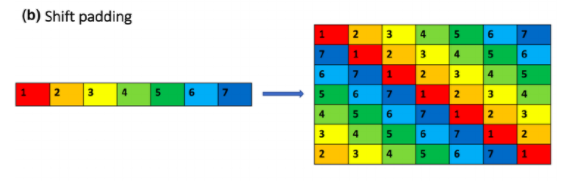

In [21]:
from IPython.display import Image

Image(filename = '/Users/cheikhtoure/Desktop/shiftPadding.png', width = 600, height = 300)

Ci_dessus est représenté à quoi représente le shift padding.


In [22]:
#Sous pytorch les labels vont de [0,...,n-1], donc je soustrais 1 à mes facies pour épouser la démarche de pytorch
df['IdxFacies']=df['Facies']-1

La procédure est la suivante pour les données d'entrainement:

* Normalisation https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html


* RandomOverSampling si sampling=True (Répéter quelques instances des classes sous représentées) https://imbalanced-learn.org/stable/generated/imblearn.over_sampling.RandomOverSampler.html



* Padding Shift décrit tout à l'heure


Pour les données test et validation:

* Normalisation

* Padding Shift

In [23]:
def shift(seq, n=0): 
    a = n % len(seq) 
    return np.array(seq[-a:]+seq[:-a])



def padding_shift(inp):
    '''
    Cette fonction prend en entrée, une liste et fait le shift padding dont 
    j'ai parlé tout à l'heure.
    
    '''
    tampon=inp*np.ones((len(inp),len(inp)))
    
    for i in range(len(tampon)):
        tampon[i,:]=shift(list(tampon[i,:]),n=i)
    return tampon  




def preproc_data(df, features=['GR', 'ILD_log10', 'DeltaPHI', 'PHIND', 'NM_M', 'RELPOS'],labels='IdxFacies',sampling=False):
    
    '''
    inputs:
            df: dataframe
            features: variable for training
            sampling (optional) default False :if True RandomOverSampling 
    outputs:
            Tensor Dataset
    
    
    '''
    
    if (df.name=='df_train') & (sampling):
        # RandomOverSampling (imbalanced class)
        preproc=StandardScaler().fit_transform(df[features])
        y=df['IdxFacies'].values
        preproc,y=RandomOverSampler(random_state=0).fit_resample(preproc,y)
        
        #padding shift
        preproc=torch.tensor([padding_shift(v) for v in preproc]).unsqueeze(1)
        y=torch.tensor(y).long()
        print(1)
        
        return TensorDataset(preproc,y)
        
        
        
    else:
        preproc=StandardScaler().fit_transform(df[features])
        preproc=torch.tensor([padding_shift(v) for v in preproc]).unsqueeze(1)
        y=torch.tensor(df['IdxFacies'].values).long()
        
        
    
        return TensorDataset(preproc,y)
    
    

je divise le jeu de données en 3 parties, entrainement, validation et test.

Le jeu de données de validation va être le ***WELL SHRIMPLIN***, sachant que le challenge sera de bien prédire cette variable.

Typiquement, on entraine le modèle sur les autres puits et on valide sur un autre puits (WELLS).

In [24]:
df_val=df[df['Well Name']=='SHRIMPLIN']

df_train,df_test=train_test_split(df[df['Well Name']!='SHANKLE'],test_size=0.1,stratify=df[df['Well Name']!='SHANKLE']['IdxFacies'],random_state=0)

df_train.name='df_train'
df_test.name='df_test'
df_val.name='df_val'

j'utilise la foncion preproc data pour prepocess mes données.

Je définis la valeur de la variable **sampling**.

In [25]:
#Cette variable sera également utiliser le loss function (avec poids ou non)
sampling=False 

dataset_train=preproc_data(df_train,sampling=sampling)

dataset_test=preproc_data(df_test)

dataset_val=preproc_data(df_val)


In [26]:
batch_size=14
train_loader = DataLoader(dataset = dataset_train, batch_size = batch_size, shuffle=True, num_workers=0)

test_loader = DataLoader(dataset = dataset_test, batch_size = 1, shuffle=True, num_workers=0)

val_loader = DataLoader(dataset = dataset_val, batch_size = 1, shuffle=True, num_workers=0)

J'utilise une architecture décrite comme suit:

* Couche de Convolution 8*3*3  (8=nombre de filtres, 3=kernel size)
* Couche Relu
* Couche de Convolution 16*3*3 (16=nombre de filtres, 3=kernel size)
* Couche de Relu
* Couche Flatten(applatit notre matrice)
* 2 couches denses

Le Loss Function utilisé dans ce cas est le CrossEntropyLoss qui supporte des poids pour les différentes classes, c'est à dire j'attribue aux classes des poids.

Plus une classe est moins représentée, plus son poids est grand.

In [27]:
#Je calcule les poids
weights=df_train['IdxFacies'].value_counts().sort_index().values  #les valeurs des différentes classes
s=sum(weights)
normedWeights = [1 - (x / s) for x in weights] #Normalisation des poids
normedWeights = torch.DoubleTensor(normedWeights)

In [28]:
class ConvFacies(nn.Module):
    def __init__(self):
        super().__init__()
        
        #shape=(w-f+2p/s)+1
        
        self.network = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=3),
            nn.ReLU(),  #shape: 4*4*8
            
            nn.Conv2d(8,16,kernel_size=3), #shape=2*2*16
            nn.ReLU(),
            

            nn.Flatten(),
            nn.Linear(in_features=2*2*16, out_features=16),
            nn.ReLU(),
            nn.Linear(16, 9))
            
    def forward(self, xb):
        return self.network(xb)

In [29]:
test_count=df_test.shape[0]

J'utilise la variable sampling définie tout à l'heure pour utiliser les poids.

L'idée est soit de faire du RandomOverSampling ou utiliser les poids dans la loss Function.

In [30]:
path='model_state_dict.pt'
best_accuracy=0



accuracy_stats = {
    'train': [],
    "test": []
}


loss_stats = {
    'train': [],
    "test": []
}




model=ConvFacies().double()
lr=0.001 #learning rate
epochs=300

if sampling:
    criterion=nn.CrossEntropyLoss()
else:
    criterion=nn.CrossEntropyLoss(weight=normedWeights)
    

optimizer=torch.optim.Adam(model.parameters(),lr)

for epoch in range(epochs):
    
    train_epoch_loss=0
    train_epoch_accuracy=0
    total=0
    
    
    for i,(inp,label) in enumerate(train_loader):
        output=model(inp)
        loss=criterion(output,label)
        
        optimizer.zero_grad() # on remet à zéro les gradients
        loss.backward() #Calcule le gradient
        optimizer.step() #mets à jour les poids et biais
        
        
        train_epoch_loss+=loss.item()  #Pour chaque epoch, je calcule le total du loss
        total+=label.size(0)
        _, predicted = torch.max(output.data, 1) #je prédis la classe
        train_epoch_accuracy+=(predicted == label).sum().item()
        
    train_epoch_loss/=total #Je prends la moyenne
    train_epoch_accuracy/=total
    loss_stats['train'].append(train_epoch_loss)
    accuracy_stats['train'].append(train_epoch_accuracy)   
    

    with torch.no_grad():
        
        model.eval()
            
        test_epoch_loss=0
        test_epoch_accuracy=0
            
        for i,(inp,label) in enumerate(test_loader):
                
            output=model(inp)
            test_loss=criterion(output,label)

            test_epoch_loss+=test_loss.item()
            _, predicted = torch.max(output.data, 1)
            test_epoch_accuracy+=(predicted == label).sum().item()

        test_epoch_loss/=test_count        
        test_epoch_accuracy/=test_count 
        loss_stats['test'].append(test_epoch_loss)
        accuracy_stats['test'].append(test_epoch_accuracy)

        
        
        
        if epoch % 100 == 0:
            print(f'epoch[{epoch+1}/{epochs}], train loss:{train_epoch_loss}')
         
        

epoch[1/300], loss:0.12407150279202109
epoch[101/300], loss:0.04855467055870174
epoch[201/300], loss:0.041870921296096965


In [31]:

# Je crée les dataframes
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})

#je trace loss and accuracy pour train et test


char1=alt.Chart(train_val_acc_df).mark_line().encode(
            x=alt.X('epochs:O',scale=alt.Scale(zero=False)),
            y=alt.Y('value:Q',scale=alt.Scale(zero=False)),
            color='variable:N').properties(height=300,width=300,title='Accuracy')


char2=alt.Chart(train_val_loss_df).mark_line().encode(
            x='epochs:O',
            y='value:Q',
            color='variable:N').properties(height=300,width=300,title='Loss')

alt.hconcat(char1,char2).resolve_scale(y='independent')

alt.HConcatChart(...)

In [32]:
def get_accuracy(data_loader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in data_loader:
            inp, labels = data
            outputs = model(inp)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    return (100 * correct / total)

La fonction ci_dessus permet de calculer l'accuracy.

$$ accuracy=\frac{nombre\ d'exemples\ bien \ classés}{nombre \ d'exemples \ total}$$

In [33]:
print(f'accuracy train: { get_accuracy(train_loader):.1f}%')

print(f'accuracy test: { get_accuracy(test_loader):.1f}%')

print(f'accuracy val: { get_accuracy(val_loader):.1f}%')

accuracy train: 79.5%
accuracy test: 65.9%
accuracy val: 63.0%


In [34]:
prediction=[]
labels = []
with torch.no_grad():
    for data in val_loader:
        inp, label = data
        outputs = model(inp)
        _, predicted = torch.max(outputs.data, 1)
        labels.append(label)
        prediction.append(predicted)
        
prediction = [a.squeeze().tolist() for a in prediction]        
labels = [a.squeeze().tolist() for a in labels]        

In [35]:
target_name=['SS','CSiS','FSiS', 'SiSH','MS','WS','D','PS','BS']
#target_names=target_name,
print(classification_report(labels, prediction,zero_division=0))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.80      0.83      0.81       118
           2       0.83      0.78      0.81       123
           3       0.73      0.61      0.67        18
           4       0.61      0.17      0.27        63
           5       0.39      0.59      0.47        63
           6       0.67      0.40      0.50         5
           7       0.47      0.60      0.53        68
           8       0.00      0.00      0.00        12

    accuracy                           0.63       470
   macro avg       0.50      0.44      0.45       470
weighted avg       0.65      0.63      0.62       470



In [36]:
idx2class={0:'SS',1:'CSiS',2:'FSiS', 3:'SiSH',4:'MS',5:'WS',6:'D',7:'PS',8:'BS'}
idx2Facies={v-1:v for v in range(1,10)}


df_confusion=pd.DataFrame(confusion_matrix(labels,prediction)).rename(columns=idx2class,index=idx2class)


In [37]:
conf=df_confusion.reset_index().melt('index')
conf.columns=['var1','var2','number']
b=alt.Chart(conf).encode(
            x=alt.X('var1:N',axis=alt.Axis(title='Prédiction')),
            y=alt.Y('var2:N',axis=alt.Axis(title='True Value'))
    )
#.properties(height=400,width=400)

rec=b.mark_rect().encode(
            color='number'
        )
text=b.mark_text().encode(
        text=alt.Text('number')
)

rec+text

alt.LayerChart(...)

In [38]:
conf=confusion_matrix(labels,prediction)
adjacent_facies = [[1], [0, 2], [1], [4], [3, 5], [4, 6, 7], [5, 7], [5, 6, 8], [6, 7]]


def accuracy_adjacent(conf, adjacent_facies):
    nb_classes = conf.shape[0]
    total_correct = 0
    for i in np.arange(0, nb_classes):
        total_correct += conf[i][i]
        for j in adjacent_facies[i]:
            total_correct += conf[i][j]
    return total_correct / sum(sum(conf))


print(f"accuracy adjacent facies: {accuracy_adjacent(conf, adjacent_facies)}")


accuracy adjacent facies: 0.8936170212765957


L'accuracy adjacent, on regarde les facies et leurs adjacents, on regarde comment se comporte l'algorithme.

On voit que la plupart des misclassifications se fait entre les Facies et leurs adjacents.

### Conclusion

Je finis cette étude par là, pour ne pas alourdir le notebook. Après 300 epochs, nous avons un score f1 de 0.63.


* Le shift padding + les poids intégrés dans le loss function améliore le score
* Comprendre la physique améliorerai nettement les données 
* J'ai divisé les données en 3 parties, on pourrait divisé en train et test (et voir si le résultat s'améliore en fonction de la quantité de données)
* On peut également tester les méthodes ensemblistes